# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [21]:
#библиотеки
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from numpy.random import RandomState
from lightgbm import LGBMRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
import time
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

In [22]:
df = pd.read_csv('/datasets/autos.csv')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [24]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Обнаружины пропуски в 
* VehicleType 37490 - тип автомобильного кузова
* Gearbox 19833 - тип коробки передач
* Model 19705 - модель автомобиля
* FuelType 32895 - тип топлива
* Repaired 71154 - была машина в ремонте или нет

### Устронение дубликатов

In [25]:
df[df.duplicated() == True]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [26]:
df = df.drop_duplicates(keep='first')
df.shape

(354365, 16)

In [27]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [28]:
df = df.drop(columns=[ 'DateCreated', 'NumberOfPictures','PostalCode', 'LastSeen' ])
#df = df[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Repaired', 'Power', 'Model', 'Kilometer', 'FuelType', 'Brand']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
dtypes: int64(5), object(7)
memory usage: 35.1+ MB


In [29]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


### Устранение пропусков

In [30]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

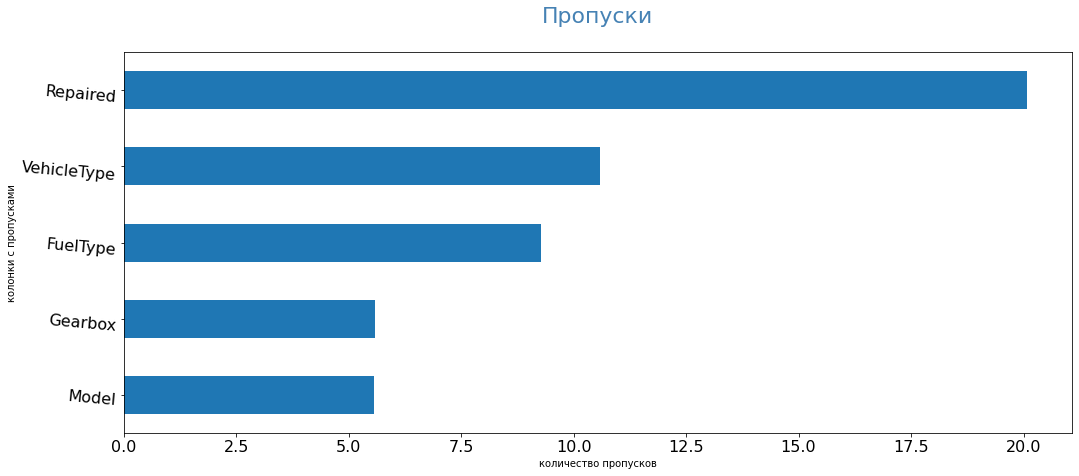

In [31]:
fig, ax = plt.subplots(figsize = (17,7))
ax = (df.isna().mean()*100).to_frame().rename(columns = {0:'space'}).query('space > 0').sort_values(by = 'space', ascending = True).plot(kind = 'barh', rot = -5, legend = False, fontsize = 16, ylabel='колонки c пропусками', ax =ax)
ax.set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')
ax.set_xlabel('количество пропусков')
plt.show()

Пропуски в VehicleType заменим на часто используемое значение по каждой категории машин в колонке Brand, т.е. модой. 

In [32]:
df['VehicleType'] = df.groupby('Brand')['VehicleType'].transform(
    lambda x: x.fillna(( x.mode()[0] if x.count()!=0 else "unknown")))

Пропуски в Gearbox так же заменим на часто используемое значение по каждой категории машин в колонке Model, т.е. модой. Но сначала пропуски в колонке Model заменим на unknown, так как тут я не вижу смылка "угадывать" по самому часто встречающемуся значению колонке Brand или еще какой либо. 

(ну либо я что-то не догнала так как  слабо разбираюсь в машинах...)

In [33]:
df['Model'] = df['Model'].fillna('unknown')
df['Gearbox'] = df.groupby('Model')['Gearbox'].transform(
    lambda x: x.fillna(( x.mode()[0] if x.count()!=0 else "unknown")))

С пропусками в FuelType сделаем то же самое что и в Gearbox.

In [34]:
df['FuelType'] = df.groupby('Model')['FuelType'].transform(
    lambda x: x.fillna(( x.mode()[0] if x.count()!=0 else "unknown")))
df['Repaired'] = df['Repaired'].fillna('no')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        354365 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            354365 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              354365 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           354365 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           354365 non-null  object
dtypes: int64(5), object(7)
memory usage: 35.1+ MB


In [36]:
df.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

### Выбросы

In [37]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650
std,4514.176349,90.228466,189.851330,37905.083858,3.726432
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


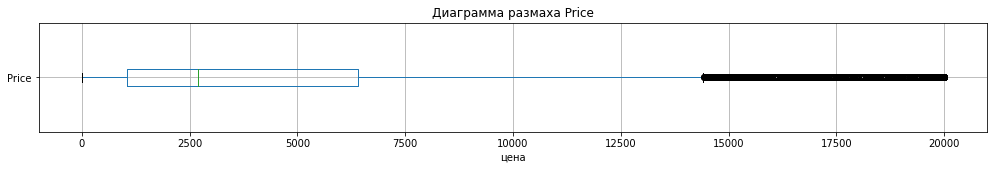

In [38]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['Price']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха Price')
ax.set_xlabel('цена')
plt.show()
#ax.set_xlim(0, 400);

А какой я график удалила, просто я вроде утром ток делала и я два графика просто меняла, я могла случайно удалить но я сижу и не могу вспомнить чего не хватает... Если помнишь напиши пожалуйста.

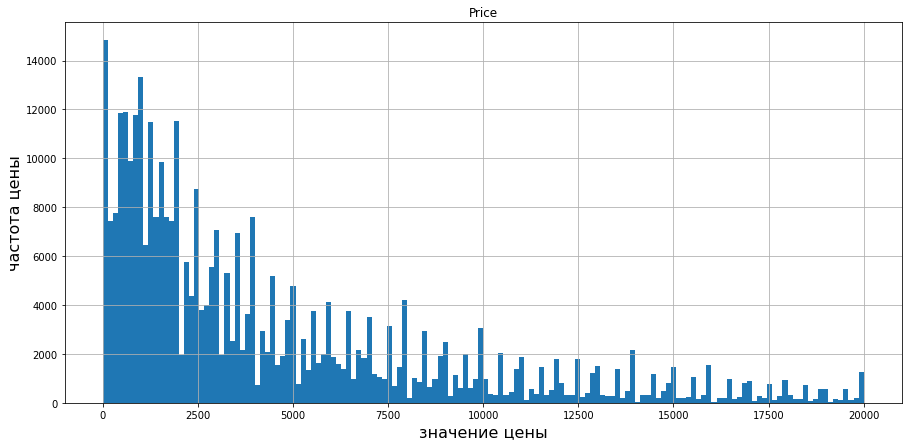

In [39]:
df['Price'].hist(bins = 150, figsize = (15,7))
plt.xlabel('значение цены', fontsize=16)
plt.ylabel('частота цены', fontsize=16)
plt.title('Price')
plt.show()

Понятное дело врятли машины за 1 евро и правда существуют. Поэтому если смотреть в рублях более мнее нормальную машины на ходу можно приобрести за 100000рублем, в евро это плюс минус 1000евро. Максимальая стоимость машины в таблице это 20т.евро. Я думаю это в полне реально, если переводить в рублт это больше 1мил.руб. 

In [40]:
df = df.query('1000 <= Price <= 10000') 

2005    18817
2004    17751
2003    17404
2006    16676
2002    15959
        ...  
8888        1
7100        1
1600        1
2500        1
7800        1
Name: RegistrationYear, Length: 115, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


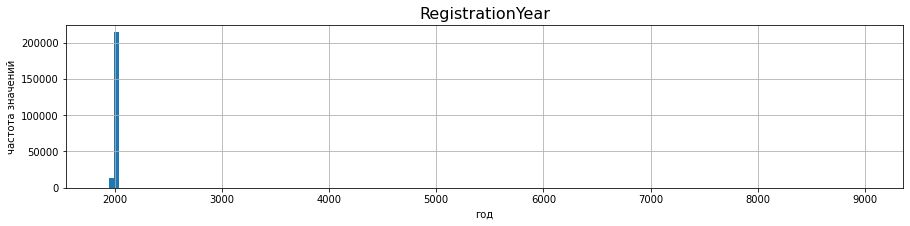

In [41]:
print(df['RegistrationYear'].value_counts())
print(df['RegistrationYear'].hist(bins = 150, figsize = (15,3), range = (1900,9000)))
plt.xlabel('год', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('RegistrationYear', fontsize=16);

In [42]:
df = df.query('1960 <= RegistrationYear < 2023') 

In [43]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
df['DateCrawled_year'] = df['DateCrawled'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227603 entries, 2 to 354368
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        227603 non-null  datetime64[ns]
 1   Price              227603 non-null  int64         
 2   VehicleType        227603 non-null  object        
 3   RegistrationYear   227603 non-null  int64         
 4   Gearbox            227603 non-null  object        
 5   Power              227603 non-null  int64         
 6   Model              227603 non-null  object        
 7   Kilometer          227603 non-null  int64         
 8   RegistrationMonth  227603 non-null  int64         
 9   FuelType           227603 non-null  object        
 10  Brand              227603 non-null  object        
 11  Repaired           227603 non-null  object        
 12  DateCrawled_year   227603 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(6)
me

In [44]:
df = df.query('DateCrawled_year >= RegistrationYear') 

Удалила где год совпадает, так как в таблице с месяцем сложно понять 0 это какой. Данных не много 4280 относительно всех, поэтому просто избавимся от них. 

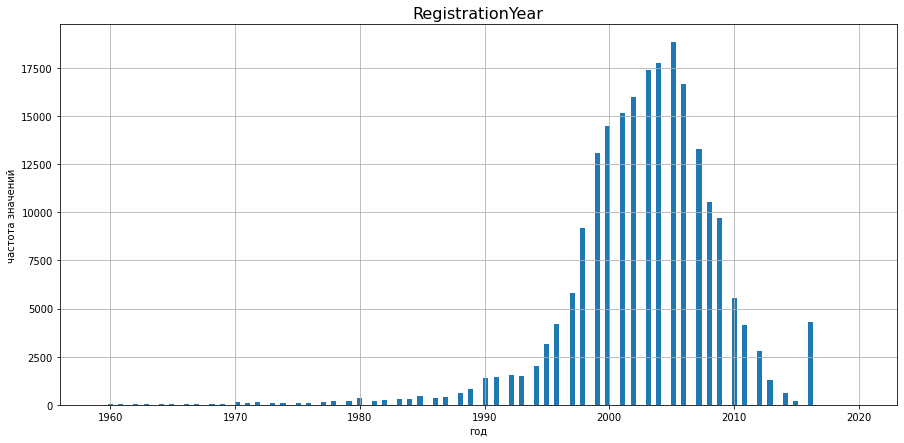

In [45]:
df['RegistrationYear'].hist(bins = 150, figsize = (15,7), range = (1959,2020))
plt.xlabel('год', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('RegistrationYear', fontsize=16);

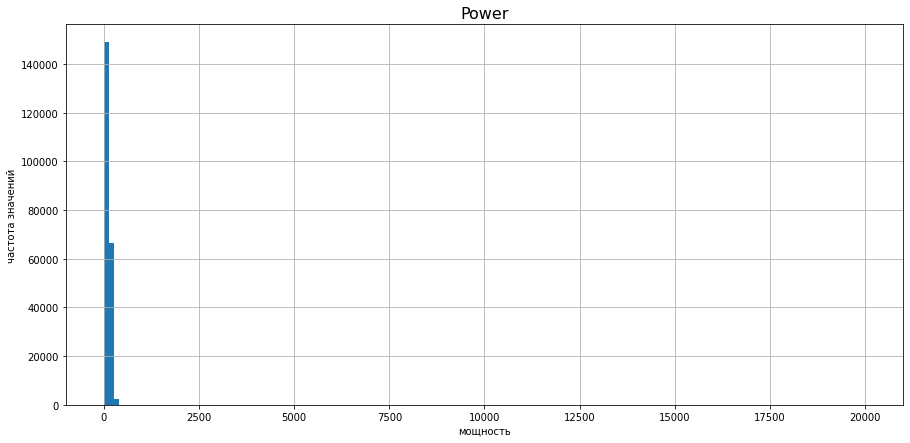

In [46]:
df['Power'].hist(bins = 150, figsize = (15,7))
plt.xlabel('мощность', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('Power', fontsize=16);

В интернете нашла статью о машине с мощьностью в 1360 л.с. минимальное значение думаю 20. 

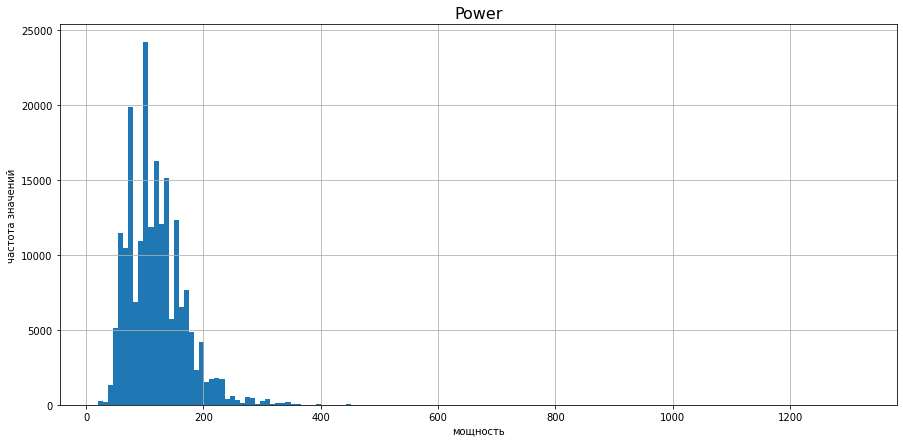

In [47]:
df = df.query('20 <= Power < 1360') 
df['Power'].hist(bins = 150, figsize = (15,7))
plt.xlabel('мощность', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('Power', fontsize=16);

у нас значений больше 400 очень малы, это выбросы их уерем. 

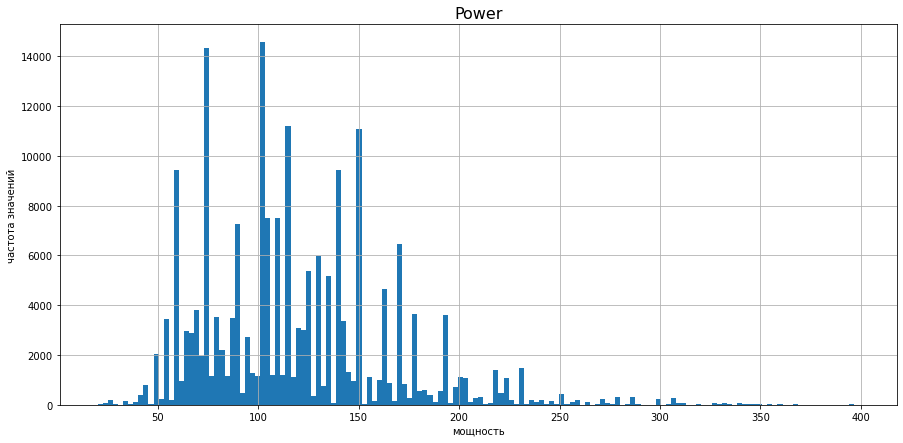

In [48]:
df = df.query('20 <= Power < 400') 
df['Power'].hist(bins = 150, figsize = (15,7))
plt.xlabel('мощность', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('Power', fontsize=16);

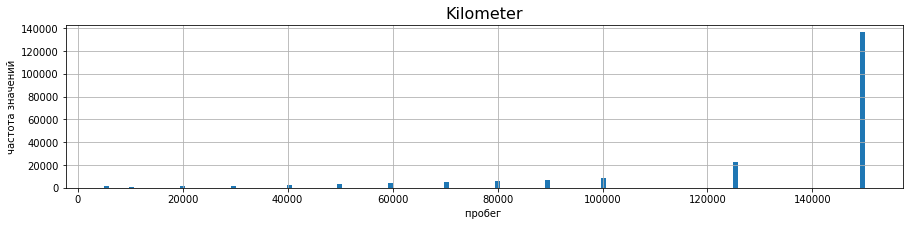

In [49]:
df['Kilometer'].hist(bins = 150, figsize = (15,3))
plt.xlabel('пробег ', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('Kilometer', fontsize=16);

С пробегом все хорошо, значения реальные.

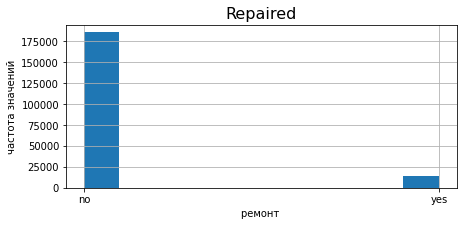

In [50]:
df['Repaired'].hist( figsize = (7,3))
plt.xlabel('ремонт ', fontsize=10)
plt.ylabel('частота значений', fontsize=10)
plt.title('Repaired', fontsize=16);

In [51]:
#удалим не нужные столбцы для обучения моделей. 
df = df.drop(columns=[ 'DateCrawled', 'RegistrationMonth','DateCrawled_year' ])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199932 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             199932 non-null  int64 
 1   VehicleType       199932 non-null  object
 2   RegistrationYear  199932 non-null  int64 
 3   Gearbox           199932 non-null  object
 4   Power             199932 non-null  int64 
 5   Model             199932 non-null  object
 6   Kilometer         199932 non-null  int64 
 7   FuelType          199932 non-null  object
 8   Brand             199932 non-null  object
 9   Repaired          199932 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.8+ MB


In [53]:
196708 * 100 / 354369

55.509370176285174

В предобработке данных было выполнено: 
* -удаление дубликатов
* -избавление от пропусков, в таблицах VehicleType, Gearbox, FuelType пропуски заменены на самое часто попадающееся значение по категориям. В Repaired пропуски заменены на no, в Model на unknown. 
* -удаление выбросов и несуществующих значений в Price, RegistrationYear, Power. В остальных значния нормальные. 
* -удаление неныжных столбцов, оставлены те которые понадобятся для построения модели.


В общей сложности осталось 56% данных от изначального количества.

## Подготовка выборок для обучения моделей

In [35]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


In [36]:
target = df['Price']
features  = df.drop(['Price'] , axis=1)

In [37]:
columns_object = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
columns_not_object = ['RegistrationYear', 'Power', 'Kilometer']

### OrdinalEncoder

In [38]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [39]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)


features_train[columns_object] = encoder.fit_transform(features_train[columns_object]) 

features_test[columns_object] = encoder.transform(features_test[columns_object])

/tmp/ipykernel_333/2776467163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[columns_object] = encoder.fit_transform(features_train[columns_object])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_333/2776467163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [40]:
features_train

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
4027,4.0,2000,1.0,101,169.0,125000,6.0,38.0,0.0
247617,7.0,2000,1.0,101,29.0,150000,2.0,1.0,0.0
350150,5.0,2005,1.0,136,58.0,150000,2.0,5.0,0.0
82663,6.0,2002,0.0,311,165.0,150000,6.0,10.0,0.0
342472,0.0,2000,1.0,116,165.0,150000,6.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...
195120,4.0,2002,1.0,125,231.0,150000,6.0,24.0,0.0
151236,7.0,1999,1.0,100,231.0,150000,6.0,24.0,0.0
236457,0.0,2007,1.0,109,60.0,125000,2.0,10.0,0.0
231361,7.0,2000,1.0,170,224.0,150000,6.0,2.0,0.0


In [41]:
features_test

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
123551,4.0,1998,1.0,110,169.0,150000,2.0,38.0,0.0
257549,7.0,2002,1.0,116,162.0,150000,6.0,31.0,1.0
301437,7.0,1994,0.0,143,15.0,150000,2.0,2.0,0.0
91031,5.0,2008,0.0,112,184.0,50000,6.0,15.0,0.0
279063,5.0,2004,0.0,61,106.0,90000,6.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...
337098,5.0,2007,1.0,68,172.0,150000,6.0,38.0,0.0
146432,2.0,1999,1.0,116,115.0,150000,6.0,38.0,0.0
238256,4.0,2004,1.0,140,33.0,150000,2.0,20.0,1.0
273369,4.0,2008,1.0,109,10.0,150000,2.0,19.0,0.0


In [42]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
10,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no


In [43]:
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train[columns_not_object])
features_train = scaler.transform(features_train[columns_not_object])
features_test[columns_not_object] = scaler.transform(features_test[columns_not_object])

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

### OneHotEncoder

In [44]:
features_columns = df.drop(['Price'] , axis=1)
features_OHE = pd.get_dummies(features_columns, drop_first=True)
features_OHE.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
6,2004,109,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,2004,105,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
features_ohe_train, features_ohe_test, target_ohe_train, target_ohe_test = train_test_split(
    features_OHE, df['Price'], test_size=0.25, random_state=12345)

In [46]:
columns_not_cat = ['RegistrationYear', 'Power', 'Kilometer']

In [47]:
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_ohe_train[columns_not_cat])
features_ohe_train[columns_not_cat] = scaler.transform(features_ohe_train[columns_not_cat])
features_ohe_test[columns_not_cat] = scaler.transform(features_ohe_test[columns_not_cat])

Разделила данные на признаки и целевой признак (цена). Сделала порядковое кодирование с помощью OrdinalEncoder(), разделила данные на тренировочную и тестовую выборки и затем провела маштабирование признаков методом StandardScaler. Вторым способом (для линейной регрессии) проделала тоже самое с OHE.

## Обучние моделей

### LinearRegression

In [51]:
%%time
model_LR = LinearRegression()
scores_LR = cross_val_score(model_LR,
                            features_ohe_train,
                            target_ohe_train,
                            cv=3,
                            verbose=10,
                            n_jobs=-1,
                            scoring='neg_root_mean_squared_error') 
RMSE_LR = (scores_LR * (-1)).mean()
print('RMSE для линейной регрессии:', RMSE_LR)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ............................ score: (test=-1704.815) total time=  13.4s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


[CV] END ............................ score: (test=-1677.424) total time=  13.3s
[CV] START .....................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s


[CV] END ............................ score: (test=-1683.554) total time=  13.8s
RMSE для линейной регрессии: 1688.5975220074463
CPU times: user 23 s, sys: 17.3 s, total: 40.3 s
Wall time: 40.6 s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.6s finished


In [62]:
%%time
start = time.time()
model_LR.fit(features_ohe_train, target_ohe_train)
t_rf_LR=round(end-start)
print('Время:',(-1) * t_rf_LR)
print()

Время: 24

CPU times: user 22.2 s, sys: 19.4 s, total: 41.6 s
Wall time: 41.6 s


In [61]:
%%time
start = time.time()
predict_time = model_LR.predict(features_ohe_train)
end = time.time()
t_rf_LR_pr=round(end-start,2)
print('Время:',t_rf_LR_pr)
print()

Время: 0.19

CPU times: user 138 ms, sys: 111 ms, total: 249 ms
Wall time: 248 ms


### RandomForestRegressor

In [64]:
%%time
best_RMSE_RTR = 100000
best_depth_RTR = 0
best_est_RTR = 0
best_model_RTR = []

for depth in tqdm(range(1, 10, 1)):
    for est in range(1, 20, 1):
        model_RTR = RandomForestRegressor(max_depth=depth, random_state=12345, n_estimators=est) 
        scores_RTR= cross_val_score(model_RTR,
                                    features_train,
                                    target_train,
                                    cv=3,
                                    n_jobs=-1,
                                    scoring='neg_root_mean_squared_error')  
        RMSE_RTR = (scores_RTR * (-1)).mean() 

        if RMSE_RTR < best_RMSE_RTR:
                    best_RMSE_RTR = RMSE_RTR 
                    best_depth_RTR = depth
                    best_est_RTR = est
                    best_model_RTR = model_RTR
            
print('RMSE для RandomForestRegressor', best_RMSE_RTR, 'Максимальная глубина:', best_depth_RTR, "Количество деревьев:", best_est_RTR)

100%|██████████| 9/9 [06:36<00:00, 44.02s/it]

RMSE для RandomForestRegressor 1334.028177039214 Максимальная глубина: 9 Количество деревьев: 19
CPU times: user 6min 34s, sys: 599 ms, total: 6min 34s
Wall time: 6min 36s


In [322]:
best_model_RTR

RandomForestRegressor(max_depth=9, n_estimators=19, random_state=12345)

In [66]:
%%time
start = time.time()
model_best_RTR = RandomForestRegressor(random_state=12345, 
                                       criterion='mse',
                                       max_depth=9, n_estimators=19)
model_best_RTR.fit(features_train, target_train)
end = time.time()
t_rf_RTR=round(end-start,2)
print('Время:',t_rf_RTR)
print()

Время: 3.65

CPU times: user 3.64 s, sys: 3.19 ms, total: 3.64 s
Wall time: 3.65 s


In [67]:
%%time
start = time.time()
predict_time_RTR = model_best_RTR.predict(features_train)
end = time.time()
t_rf_RTR_pr=round(end-start,2)
print('Время:',t_rf_RTR_pr)
print()

Время: 0.27

CPU times: user 258 ms, sys: 0 ns, total: 258 ms
Wall time: 265 ms


### LGBMRegressor

In [43]:
# check lightgbm version
import lightgbm
print(lightgbm.__version__)

3.3.1


In [324]:
# 2 вариант 
%time
param_grid = {
    'learning_rate': [0.4, 0.1, 0.01],
    'n_estimators': [50, 100, 150, 1000],
    'max_depth': [4, 6]
}


estimator = lgb.LGBMRegressor(objective='regression', 
                              random_state=12345)

model = GridSearchCV(estimator=estimator, 
                     param_grid=param_grid,
                     cv=3, 
                     n_jobs=-1, 
                     verbose=10,
                     scoring='neg_root_mean_squared_error')
model.fit(features_train, target_train)

best_params = model.best_params_
print(model.best_score_ * (-1))
print('-------------')
print(best_params)
print('-------------')
print(model.best_estimator_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START learning_rate=0.4, max_depth=4, n_estimators=50............
[CV 1/3; 1/24] END learning_rate=0.4, max_depth=4, n_estimators=50; total time= 1.1min
[CV 2/3; 1/24] START learning_rate=0.4, max_depth=4, n_estimators=50............
[CV 2/3; 1/24] END learning_rate=0.4, max_depth=4, n_estimators=50; total time= 1.2min
[CV 3/3; 1/24] START learning_rate=0.4, max_depth=4, n_estimators=50............
[CV 3/3; 1/24] END learning_rate=0.4, max_depth=4, n_estimators=50; total time= 1.3min
[CV 1/3; 2/24] START learning_rate=0.4, max_depth=4, n_estimators=100...........
[CV 1/3; 2/24] END learning_rate=0.4, max_depth=4, n_estimators=100; total time= 2.2min
[CV 2/3; 2/24] START learning_rate=0.4, max_depth=4, n_estimators=100...........
[CV 2/3; 2/24] END learning_rate=0.4, max_depth=4, n_estimators=100; total time=   2.2s
[CV 3/3; 2/24] START learning_rat

Итоговое время обучения 451мин

In [70]:
%%time
start = time.time()
model_best_LGBMR = lgb.LGBMRegressor( learning_rate=0.1, max_depth=6, n_estimators=1000, 
                                     random_state=12345, objective='regression')
model_best_LGBMR.fit(features_train, target_train, verbose=10)
end = time.time()
t_rf_LGBMR=round(end-start)
print('Время:',t_rf_LGBMR)
print()

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Время: 1547

CPU times: user 25min 18s, sys: 18.1 s, total: 25min 36s
Wall time: 25min 46s


In [71]:
%%time
start = time.time()
model_best_LGBMR.predict(features_train)
end = time.time()
t_rf_LGBMR_pr=round(end-start)
print('Время:',t_rf_LGBMR_pr)
print()

Время: 19

CPU times: user 19 s, sys: 0 ns, total: 19 s
Wall time: 19 s


### DummyRegressor

In [49]:
%%time
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predict_dummy_mean = dummy_regr.predict(features_test)
mean_squared_error(target_test, predict_dummy_mean) ** 0.5

CPU times: user 3.27 ms, sys: 204 µs, total: 3.47 ms
Wall time: 2.14 ms


2505.878882026043

## Анализ моделей

In [73]:
index = ['RMSE', 'time fit', 'time predict']
analysis = {'LinearRegression (сек)':[RMSE_LR, t_rf_LR, t_rf_LR_pr],
            'RandomForestRegressor (сек)':[best_RMSE_RTR, t_rf_RTR, t_rf_RTR_pr ],
            'LGBMRegressor (сек)':['1128.296', t_rf_LGBMR, t_rf_LGBMR_pr]}
analysis_itog = pd.DataFrame(data=analysis, index=index)
analysis_itog

,LinearRegression (сек),RandomForestRegressor (сек),LGBMRegressor (сек)
RMSE,1688.597522,1334.028177,1128.296
time fit,-24.000000,3.650000,1547
time predict,0.190000,0.270000,19


Лучшая модель по показателю RMSE это LGBMRegressor, но по времени обучения она чуть дольше чем RandomForestRegressor.

## Проверка на тестовой выборки

Выберу лучшую модель LGBMRegressor и проверю ее на тестовой выборке. 

In [74]:
model_best_LGBMR

LGBMRegressor(max_depth=6, n_estimators=1000, objective='regression',
              random_state=12345)

In [75]:
%%time
predict = model_best_LGBMR.predict(features_test)
RMSE_test = mean_squared_error(target_test, predict) ** 0.5
RMSE_test

CPU times: user 5.87 s, sys: 0 ns, total: 5.87 s
Wall time: 5.82 s


1119.6650576276952

На тестовой выборке показатель RMSE лучшей модели model_best_LGBMR 1119.6, на тренировочных данныйх результат был 1128.296. Время предсказания 5.82 s. 

Для заказчика порекомендовала бы эту модель, у нее хороший показатель метрики, и достаточно быстрое время обучения и предсказания, но конечно не самое быстрое, как у RandomForestRegressor, но там хуже показатель метрики. Поэтому критериям заказчика модель удовлетворяет. 